In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import time
from functions import point_matching, normalize_keypoints, SuperPointWithAffNetScaleNetKornia
from kornia_moons.viz import visualize_LAF, draw_LAF_matches
import kornia as K
import kornia.feature as KF
from kornia_moons.feature import *
import pystereoglue
import sys

In [2]:
# Parameters
device = torch.device('cuda')
depth_anything_path = "/media/hdd3tb/sdk/Depth-Anything-V2"
depth_anything_encoder = "vits"

# Load the feature extractor
detector = SuperPointWithAffNetScaleNetKornia(init_scale = 20, upright = True).to(device)

# Load the image matching model
matcher = KF.LightGlue('superpoint', width_confidence=-1, depth_confidence=-1).eval().to(device)

# StereoGlue parameters
pool_size = 3
inlier_threshold = 5
core_number = 8

/local/home/dbarath/anaconda3/envs/main/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/home/dbarath/anaconda3/envs/main/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded LightGlue model


In [3]:
# Check if the images are already downloaded
if not os.path.exists('kn_church-8.jpg'):
    %%capture
    !wget https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg
    !wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg

K1 = np.identity(3)
K2 = np.identity(3)

In [4]:
def load_image(fn):
    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    return K.image_to_tensor(img, False).float() / 255.

In [5]:
img1 = load_image('kn_church-8.jpg')
img2 = load_image('kn_church-2.jpg')

img1 = img1.squeeze(0).to(device)
img2 = img2.squeeze(0).to(device)

image_size1 = img1.shape
image_size2 = img2.shape

In [6]:
start_time = time.time()
lafs1, r1, desc_1_sp, desc_1_hn = detector(img1)
end_time = time.time()
print(f"{lafs1.shape[1]} keypoints are found in {end_time - start_time:.2f} seconds")

start_time = time.time()
lafs2, r2, desc_2_sp, desc_2_hn = detector(img2)
end_time = time.time()
print(f"{lafs2.shape[1]} keypoints are found in {end_time - start_time:.2f} seconds")

2048 keypoints are found in 0.39 seconds
2048 keypoints are found in 0.08 seconds


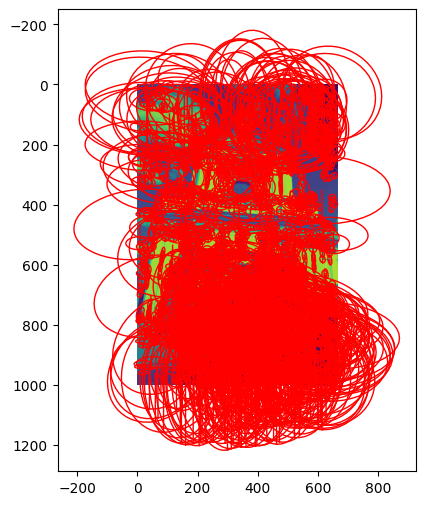

In [7]:
fig = visualize_LAF(img1, torch.tensor(lafs1), figsize=(8,6))     

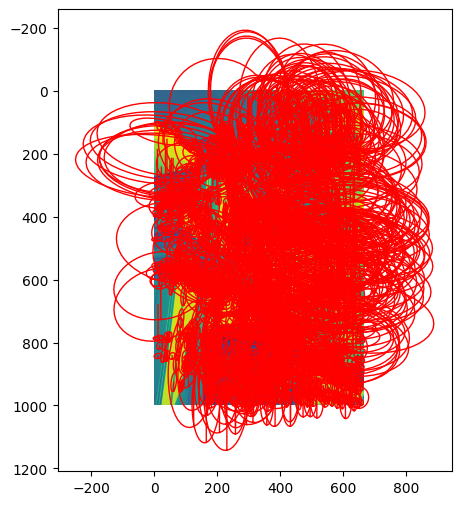

In [8]:
fig = visualize_LAF(img2, torch.tensor(lafs2), figsize=(8,6))     

In [9]:
# Select the last column of the LAFs (1 * n * 2 * 3) and make a matrix of 2D points
kps1 = lafs1[0, :, :2, 2].reshape(1, -1, 2)
kps2 = lafs2[0, :, :2, 2].reshape(1, -1, 2)

desc_1_sp = desc_1_sp.reshape(1, -1, 256)
desc_2_sp = desc_2_sp.reshape(1, -1, 256)

r1 = r1.reshape(1, -1)
r2 = r2.reshape(1, -1)

image_size_1 = torch.tensor([img1.shape[2], img1.shape[1]], dtype=torch.int32, device=device)
image_size_2 = torch.tensor([img2.shape[2], img2.shape[1]], dtype=torch.int32, device=device)
image_size_1 = image_size_1.reshape(1, 2)
image_size_2 = image_size_2.reshape(1, 2)

feats1 = { "keypoints": torch.from_numpy(kps1).to(device), "descriptors": torch.from_numpy(desc_1_sp).to(device), 'image_size': image_size_1 }
feats2 = { "keypoints": torch.from_numpy(kps2).to(device), "descriptors": torch.from_numpy(desc_2_sp).to(device), 'image_size': image_size_2 }

# Detect keypoints by LightGlue
start_time = time.time()
matches, scores = point_matching(feats1, feats2, matcher)
end_time = time.time()
    
# Reshape the LAFs from 1 * n * 2 * 3 to n * 6
matches = matches[:, : pool_size]
scores = scores[:, : pool_size]

# Reshape the LAFs from 1 * n * 2 * 3 to n * 6
reshaped_lafs1 = lafs1.reshape(-1, 6)
reshaped_lafs2 = lafs2.reshape(-1, 6)

# Remove rows from the matches where the first value is -1
mask = matches[:, 0] != -1
matches = matches[mask, :]
scores = scores[mask]
reshaped_lafs1 = reshaped_lafs1[mask, :]

# Swap the columns of the LAFs so that the coordinates comes first
reshaped_lafs1 = reshaped_lafs1[:, [2, 5, 0, 1, 3, 4]]
reshaped_lafs2 = reshaped_lafs2[:, [2, 5, 0, 1, 3, 4]]

print(f"{matches.shape[0]} matches are found in {end_time - start_time:.2f} seconds")

410 matches are found in 0.13 seconds


In [10]:
def predict_monodepth(model, image):
    # HxW raw depth map in numpy
    disparity = model.infer_image(image) 
    # Clamping the farthest depth to 100x of the nearest
    range1 = np.minimum(disparity.max() / (disparity.min() + 0.001), 100.0)
    max1 = disparity.max()
    min1 = max1 / range1
    
    depth = 1 / np.maximum (disparity, min1)
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    return depth

def border_interpolate(value, limit):
    """Handles border reflection as in cv::borderInterpolate with BORDER_REFLECT_101."""
    value = np.where(value < 0, -value - 1, value)
    value = np.where(value >= limit, 2 * limit - value - 1, value)
    return value

def sample_bilinear(depth_image, rows, cols, x, y):
    """
    Vectorized bilinear interpolation function to sample depth values from a depth image.
    
    Parameters:
    - depth_image: 2D numpy array containing depth values.
    - rows: Number of rows in the image.
    - cols: Number of columns in the image.
    - x: Array of x-coordinates.
    - y: Array of y-coordinates.

    Returns:
    - Interpolated depth values for each (x, y) coordinate pair.
    """
    # Floor the coordinates
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    
    # Get the next coordinates
    x1 = x0 + 1
    y1 = y0 + 1

    # Apply border interpolation (reflection at the image edges)
    x0 = border_interpolate(x0, cols)
    x1 = border_interpolate(x1, cols)
    y0 = border_interpolate(y0, rows)
    y1 = border_interpolate(y1, rows)

    # Compute the fractional part for interpolation
    a = x - x0
    c = y - y0

    # Perform bilinear interpolation
    top_left = depth_image[y0, x0]
    top_right = depth_image[y0, x1]
    bottom_left = depth_image[y1, x0]
    bottom_right = depth_image[y1, x1]

    interpolated_values = (top_left * (1 - a) + top_right * a) * (1 - c) + \
                          (bottom_left * (1 - a) + bottom_right * a) * c

    return interpolated_values

def prepare_depth(lafs, depth, step_size = 0.9):
    rows = depth.shape[0]
    cols = depth.shape[1]

    # Get the points
    points = lafs[0,:,:,2]

    # Get the affine shapes
    A = lafs[0,:,:,:2]

    # Sample lambda (depth at keypoints)
    lambda_vals = sample_bilinear(depth, rows, cols, points[:, 0], points[:, 1])

    # Create shifted points for dxx and dxy calculations
    dxx_shift_pos = points + A[:, :, 0] * step_size
    dxx_shift_neg = points - A[:, :, 0] * step_size
    dxy_shift_pos = points + A[:, :, 1] * step_size
    dxy_shift_neg = points - A[:, :, 1] * step_size
    
    # Sample bilinear depths at shifted points for dxx and dxy
    dxx_pos = sample_bilinear(depth, rows, cols, dxx_shift_pos[:, 0], dxx_shift_pos[:, 1])
    dxx_neg = sample_bilinear(depth, rows, cols, dxx_shift_neg[:, 0], dxx_shift_neg[:, 1])
    dxy_pos = sample_bilinear(depth, rows, cols, dxy_shift_pos[:, 0], dxy_shift_pos[:, 1])
    dxy_neg = sample_bilinear(depth, rows, cols, dxy_shift_neg[:, 0], dxy_shift_neg[:, 1])

    # Calculate dxx and dxy (finite differences)
    dxx = dxx_pos - dxx_neg
    dxy = dxy_pos - dxy_neg

    # Prepare the depth information (lambda, dxx, dxy)
    feature_depth = np.stack((lambda_vals, dxx, dxy), axis=1)
    return feature_depth

In [11]:
print("Initialize Depth Anything v2 for monocular depth prediction")
sys.path.append(depth_anything_path)
from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

depth_model = DepthAnythingV2(**model_configs[depth_anything_encoder])
depth_model.load_state_dict(torch.load(f'{depth_anything_path}/checkpoints/depth_anything_v2_{depth_anything_encoder}.pth', map_location='cpu'))
depth_model = depth_model.to(device).eval()

Initialize Depth Anything v2 for monocular depth prediction


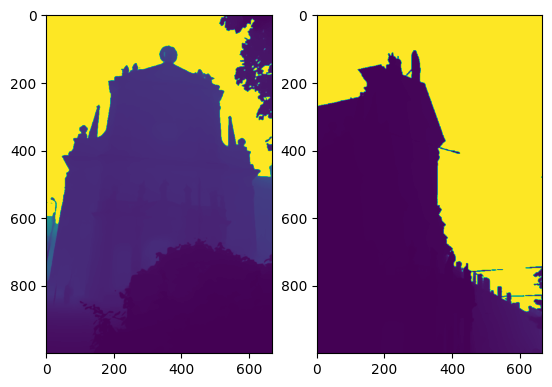

In [12]:
depth1 = predict_monodepth(depth_model, cv2.imread('kn_church-8.jpg'))
depth2 = predict_monodepth(depth_model, cv2.imread('kn_church-2.jpg'))
depth1 = depth1 / depth1.max()
depth2 = depth2 / depth2.max()

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(depth1)
ax2.imshow(depth2)


In [13]:
# Calculate the depth tangents
depth_tangents1 = prepare_depth(lafs1[:, mask, :, :], depth1)
depth_tangents2 = prepare_depth(lafs2, depth2)

In [14]:
# Set up the configuration
config = pystereoglue.RANSACSettings()
config.inlier_threshold = inlier_threshold
config.core_number = core_number
config.scoring = pystereoglue.ScoringType.MAGSAC
config.local_optimization = pystereoglue.LocalOptimizationType.NestedRANSAC
config.final_optimization = pystereoglue.LocalOptimizationType.LSQ

In [15]:
if matches.shape[0] > 1:
    # Prepare the LAFs and depth tangents
    lafs_and_depth1 = np.hstack((reshaped_lafs1, depth_tangents1))
    lafs_and_depth2 = np.hstack((reshaped_lafs2, depth_tangents2))

    # Run the homography estimation implemented in OpenCV
    tic = time.perf_counter()
    F_est, inliers, score, iterations = pystereoglue.estimateFundamentalMatrix(
        np.ascontiguousarray(lafs_and_depth1),
        np.ascontiguousarray(lafs_and_depth2),
        np.ascontiguousarray(matches), 
        np.ascontiguousarray(scores), 
        [image_size1[2], image_size1[1], image_size2[2], image_size2[1]],
        config = config)
    toc = time.perf_counter()
    elapsed_time = toc - tic
    
print(f"Inlier number: {len(inliers)}")
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Inlier number: 409
Elapsed time: 0.32 seconds


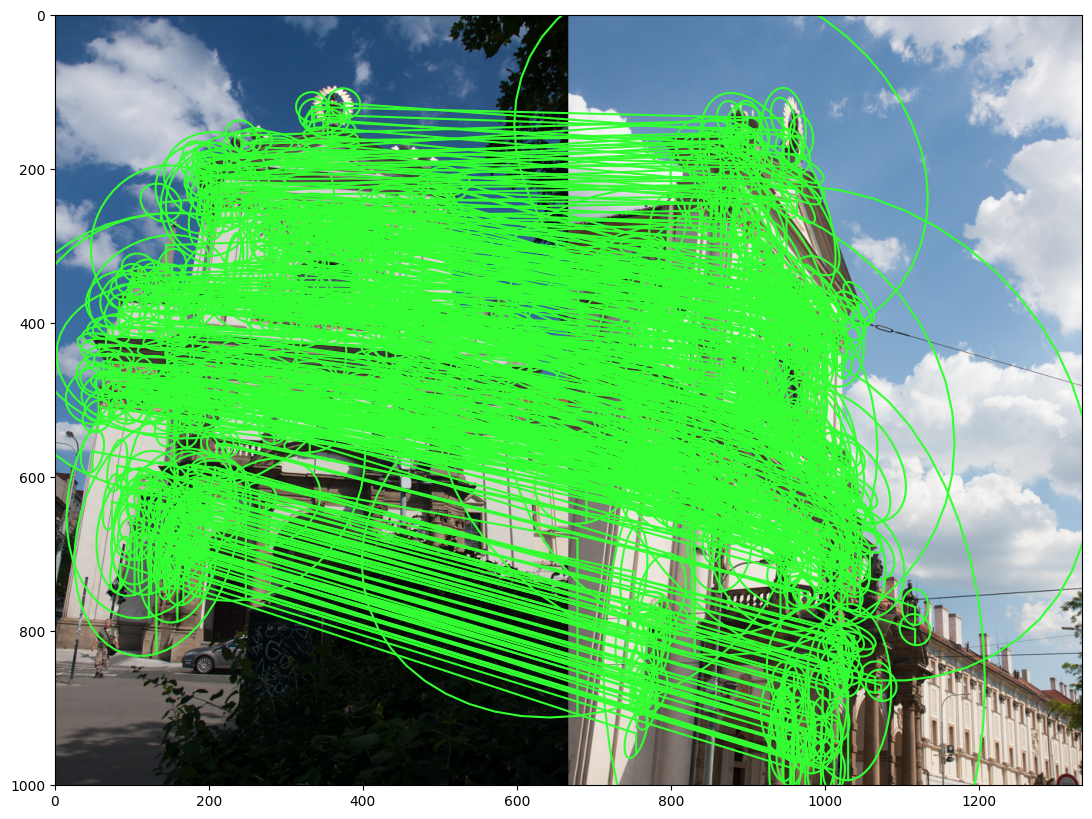

In [16]:
draw_LAF_matches(
    torch.tensor(lafs1[:, mask, :, :]),
    torch.tensor(lafs2),
    np.array(inliers),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    np.ones((len(inliers),)),
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': None, 'vertical': False})